# Notes too self:
I have got to put more of his in functions cause this is so busy!
20
I want to run this again on the wonderful 20-60 first images found in the other dataset! I think that will give a much prettier image 

In [66]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from PIL import Image
import cv2
import pandas as pd
import imutils
from cellpose import utils, io
from scipy.spatial import distance as dist
from imutils import perspective
import re
import tools

segments_path = "/home/keeganfl/Desktop/Math_612_project/05-10-2015/cellpose_height/"

# Step 1
Loading up a list of segmentation (.npy) files to be run through the process. These files are then sorted by timepoint.

In [2]:
files = os.listdir(segments_path)
for fichier in files[:]: 
    if not(fichier.endswith(".npy")):
        files.remove(fichier)
        
files.sort(key = tools.natural_keys)

# Step 2
Loading up the data and specifically saving the full image and outlines for each file.

In [3]:
dat_list = []
outl_list = []
img_list = []
for file in files[8:]:
    dat = np.load(segments_path + file, allow_pickle=True).item()
    dat_list.append(dat)
    # Create a list that contains each outline.
    outl = tools.outlines_list(dat['masks'])
    outl_list.append(outl)
    # Create a list that contains each image file. 
    img = dat["img"]
    img_list.append(img)

# Step 3
Look at the individual outlines. (I mostly use this to get the context of where each outline is in the full image)

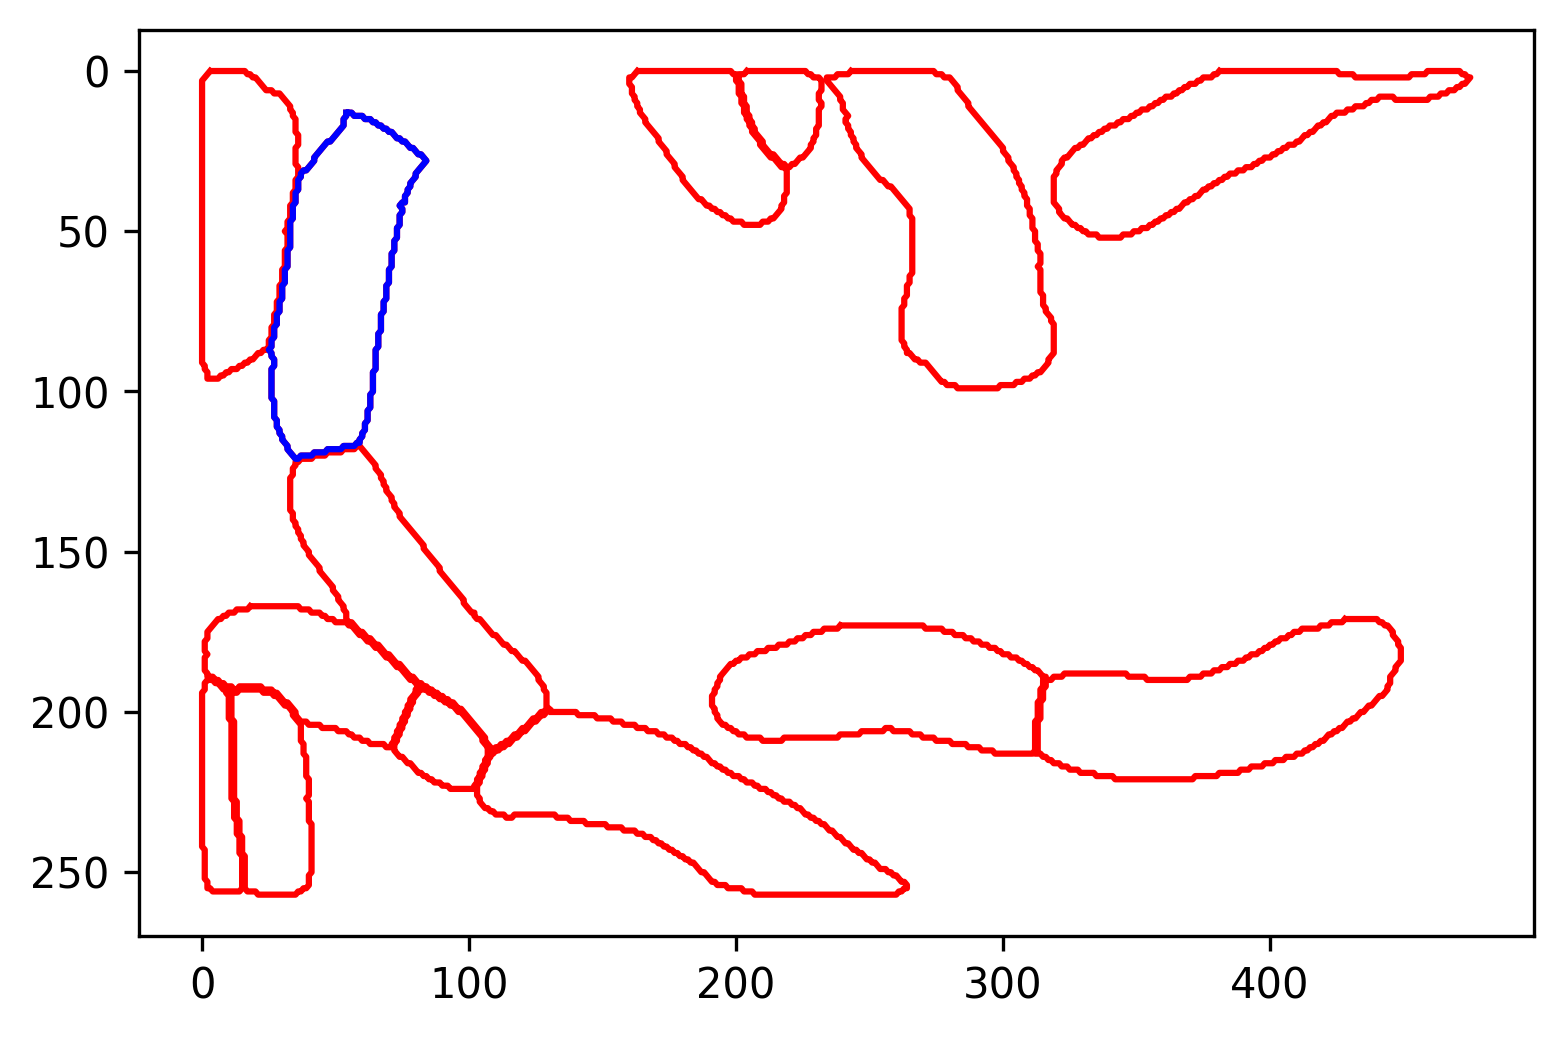

In [4]:
#plot just the outlines. I mostly use this to get a sense for each outline. 
for o in outl_list[3]:
    plt.plot(o[:,0], o[:,1], color='r')
plt.plot(outl_list[3][5][:,0], outl_list[3][5][:,1], color = 'blue')
plt.gca().invert_yaxis()

# Step 4
Create bounding boxes for each outline in each image. 

In [22]:
boxes_list = []
for outl in outl_list:
    boxes = tools.get_boxes(outl)
    boxes_list.append(boxes)

# Tracking

In [26]:
# initialize our centroid tracker and frame dimensions
ct = tools.CentroidTracker()
(H, W) = (None, None) ## Perhaps I could fix my issues with frame by messing with this? 

# loop over the images and their boxes.
IDs_list = []
outlines_new_list = []
centers_list = []
for rects, img, outls in zip(boxes_list, img_list, outl_list):
    for box in rects:
        (startX, startY, endX, endY) = box.astype("int")
        cv2.drawContours(img, [box.astype("int")], -1, (0, 255, 0), 2)
    # update our centroid tracker using the computed set of bounding
    # box rectangles
    objects = ct.update(rects, outls)
    # loop over the tracked objects
    IDs = []
    outlines_new = []
    centers = []
    for (objectID, info) in objects.items(): ###!!!### This is going to be key for figuring out what is what
        # draw both the ID of the object and the centroid of the
        # object on the output frame
        text = "ID {}".format(objectID)
        cv2.putText(img, text, (info[0][0] - 10, info[0][1] - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.circle(img, (info[0][0], info[0][1]), 4, (0, 255, 0), -1)
        IDs.append(objectID)
        outlines_new.append(info[1])
        centers.append(info[0])
    IDs_list.append(IDs)
    outlines_new_list.append(outlines_new)
    centers_list.append(centers)

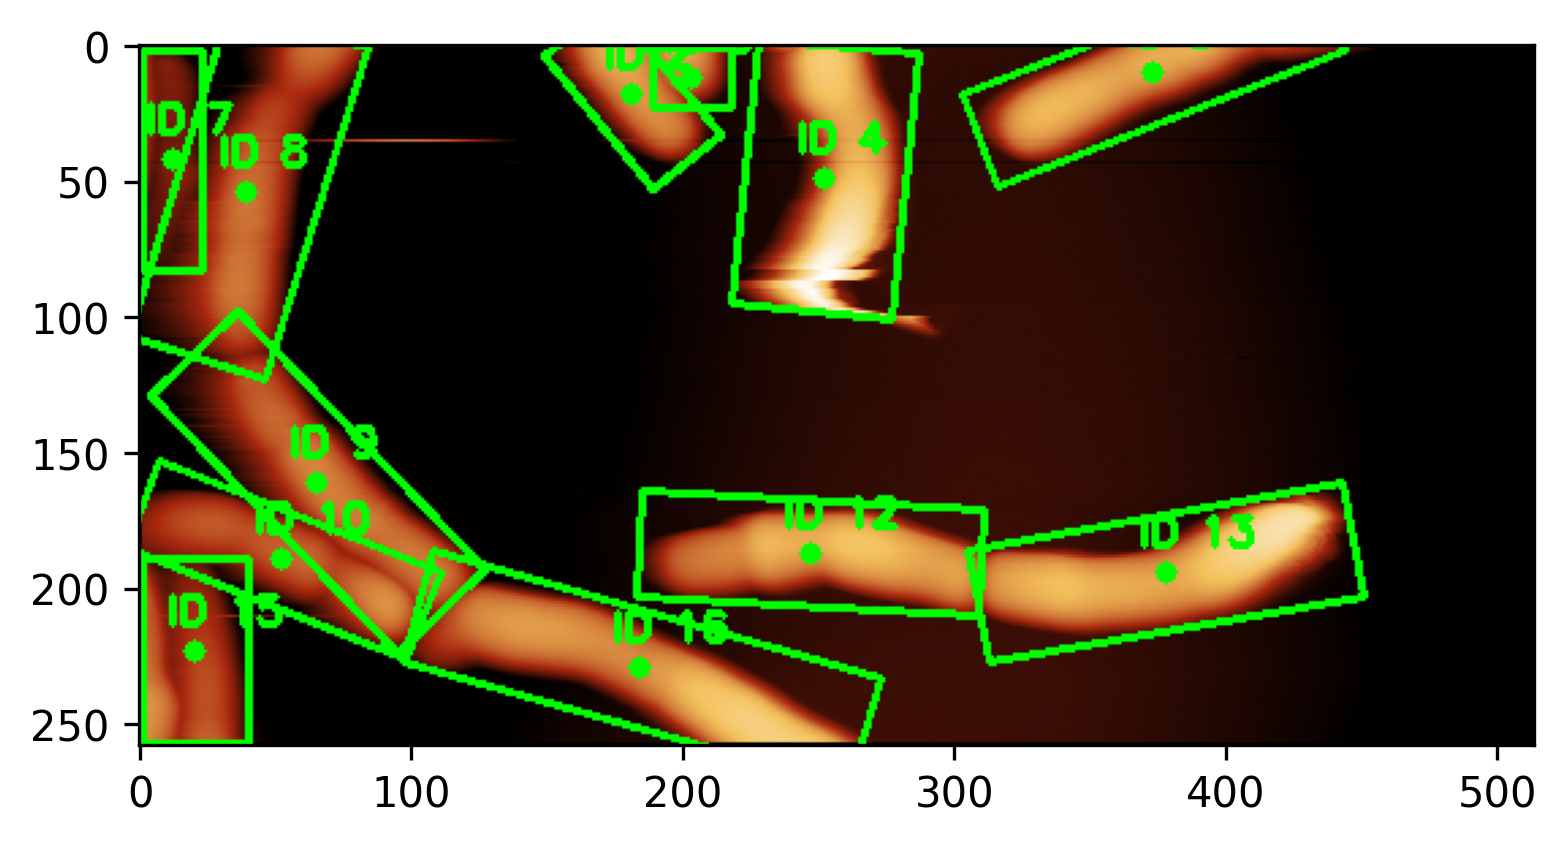

In [122]:
plt.imshow(img_list[4])

# Determining overlap
... This goes a lot quicker than I thought on multiple images. 

In [27]:
# hmmmm, this takes like, 10 seconds to run, and for an image of this size that is pretty pathetic... 
overl_list = []
for outl, centers in zip(outlines_new_list, centers_list):
    cell_overlaps = []
    for out_cell, cen_cell in zip(outl, centers):
        adj = 0
        for out_oth, cen_oth in zip(outl, centers):
            cent_dist = dist.euclidean(cen_cell,cen_oth)
            if cent_dist > 150 or cent_dist == 0:
                continue
            for pixel1 in out_cell:
                for pixel2 in out_oth:
                    distx = np.abs(pixel1[0]-pixel2[0])
                    disty = np.abs(pixel1[1]-pixel2[1])
                    if distx + disty == 1:
                        adj = adj + 1
        cell_overlaps.append(adj)
    overl_list.append(cell_overlaps)

### For now, I have set a cuttoff for possible overlaps at 150 pixels distance from the centroid.

# Putting it all together. 

I want to start creating a table where, for each cell, we have the perimeter, the area, the amount of overlap, the position of the center, and the ID. Oh, also I want to extract the times from the names.

In [119]:
# calculate some extra values. 
per_list = []
for outl in outlines_new_list: # No, wrong, bad. 
    perimeters = []
    for o in outl:
        perimeters.append(cv2.arcLength(o, True))
    per_list.append(perimeters)
    
area_list = []
for outl in outlines_new_list:
    areas = []
    for o in outl:
        areas.append(cv2.contourArea(o))
    area_list.append(areas)
    
#times_list

In [57]:
def get_max_ID(IDs_list):
    maxi = []
    for ID_set in IDs_list:
        maxi.append(max(ID_set))
    return max(maxi)

In [101]:
def get_metadata(exact_ID, IDs_list, per_list, area_list, overl_list, centers_list):
    data = []
    for ID_set, per_set, area_set, overl_set, centers_set in zip(IDs_list, per_list, area_list, overl_list, centers_list):
        for ID, per, area, overl, center in zip(ID_set, per_set, area_set, overl_set, centers_set):
            if ID == exact_ID:
                data.append(dict(zip(["perimeter","area", "overl_set", "centers_set"], [per, area, overl, center])))
    df = pd.DataFrame(data)
    return(df)
### !!! ### It might actually be good to create a list of NA's for each timepoint a cell is not present for. 

In [120]:
get_metadata(3, IDs_list, per_list, area_list, overl_list, centers_list)

,perimeter,area,overl_set,centers_set
0,99.112698,611.0,39,"[232, 15]"
1,101.840620,607.5,46,"[224, 15]"
2,103.355338,667.5,47,"[224, 16]"
3,105.254833,675.0,49,"[216, 15]"
4,86.769552,446.0,42,"[203, 12]"
5,88.183766,482.5,42,"[203, 12]"


In [121]:
max_ID = get_max_ID(IDs_list)
for i in range(max_ID):
    df = get_metadata(i, IDs_list, per_list, area_list, overl_list, centers_list)
    df.to_csv("metadata/cell_id_" + str(i) + ".csv", index = False)

hmmmm, each alternate data point based on the ID, not the order. 

## Save individual masks as png files

In [ ]:
for ID_set, outl in zip(IDs_list, outlines_new_list)
    for idx, cell in zip(outl[:]):
        # mask outline
        mask = np.zeros(img.shape[0:2], dtype=np.uint8)
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,)*channel_count
        cv2.fillPoly(mask, [cell], ignore_mask_color)
    
        # crop the cell
        x = cell.flatten()[::2]
        y = cell.flatten()[1::2]

        (topy, topx) = (np.min(y), np.min(x))
        (bottomy, bottomx) = (np.max(y), np.max(x))
        out = mask[topy:bottomy+1, topx:bottomx+1]
    
        #cv2.imwrite(os.path.join(name, str(idx) + ".png" ), out)
        im = Image.fromarray(out)
        im.save("Individual_masks/" + str(idx) + ".png")

In [ ]:
# Working on how I would like to save all of this metadata to file. 

def save_metadata(count_vectors, path_to_save):
    # Calculate the longest cds region in our new list of counts
    l_tr = find_max_list(count_vectors)

    # Define a header that includes labels for each value.
    header=["transcript_id","gene_id"]

    # insert that header into our counts list. 
    count_vectors.insert(0,header)
    
    # Save the newly altered list as a csv. 
    with open(path_to_save, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(count_vectors)

# Goals:
- Find center of all contours. Completed!!!
- Calculate if contours are touching each other and how much overlap there is. Completed!!! But improvements can be made to speed.
- Tell how distant the cell was from other contours in general? 
- Where was the cell in the overall image. 
- What was the time point of this image. Can calculate based on image name? 
- Use optical flow to track cell movement on a basic level. 
- Find a way to auto filter those weird looking cells. 
- What am I going to do when the pngs seem to change size randomly? Will any tracking I implement be able to cope? 
- How do I determine if cells are dividing vs being smushed together? Need the help of the actual data points? only bacteria connected pole to pole are touching? Take into account the time tracking? Maybe it should have an event for when a new cell appears? Would such an event be biased by artifacts that occasionally split one cell into two cells? 

#### Hmmm, I need to start thinking of how I really want all of this to be organized. Like, I have to seperate every cell, but does he want me to put them back together? What are we trying to do with all this data?

# Ultimate goal. 
For each cell, there is a table of metadata. The columns of this metadata table are the parameters we are interested in (overlap, length of skeleton, ridgeline, etc) The rows of the table are time points, so that at each timepoint we have every parameter of interest. This could allow us to see things like the volume change after division or the path of movement that a cell takes.

# Note on potential issue:
I have noticed that the AFM data tends to create these "fault lines" where one cell ends up being split in two by some kind of glitch along the scanning line. This may be of some concern given that cellpose tends to think that these split cells are actually seperate cells. 

# Tracking

In [ ]:
# initialize our centroid tracker and frame dimensions
ct = tools.CentroidTracker()
(H, W) = (None, None) ## Perhaps I could fix my issues with frame by messing with this? 

# loop over the images and their boxes.
for rects, img in zip(boxes_list, img_list):
    for box in rects:
        (startX, startY, endX, endY) = box.astype("int")
        cv2.drawContours(img, [box.astype("int")], -1, (0, 255, 0), 2)
    # update our centroid tracker using the computed set of bounding
    # box rectangles
    objects = ct.update(rects)
    # loop over the tracked objects
    for (objectID, centroid) in objects.items(): ###!!!### This is going to be key for figuring out what is ha
        # draw both the ID of the object and the centroid of the
        # object on the output frame
        text = "ID {}".format(objectID)
        cv2.putText(img, text, (centroid[0] - 10, centroid[1] - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.circle(img, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)
    
    
### !!! ### The code below was meant to show the output frames. However, 
### !!! ### the code is so fast that this basically breaks as we go through the "video" in 1/8 of a second. 
#cv2.imshow("Frame", img)
    #key = cv2.waitKey(1) & 0xFF
    # if the `q` key was pressed, break from the loop
    #if key == ord("q"):
    #    break
#cv2.destroyAllWindows()

In [ ]:
plt.imshow(img_list[9])

It works somewhat ok.

Some of the problems are that it actually does not quite deregister fast enough, which occasionally makes the phantom centroids very dangerous. 

Also, how the hell do I actually extract the ID information from in here? 